# Import Library

In [1]:
import re
import string
import emoji
import pandas as pd
import numpy as np
import ast
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from gensim.models import Word2Vec

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Input, Embedding, LSTM, Bidirectional
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.regularizers import l2
from imblearn.over_sampling import SMOTE

import nltk
nltk.download('punkt_tab')  # Mengunduh dataset yang diperlukan untuk tokenisasi teks.
nltk.download('stopwords')  # Mengunduh dataset yang berisi daftar kata-kata berhenti (stopwords) dalam berbagai bahasa.

from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords 
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TextClassificationPipeline
from tqdm import tqdm


[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\lenovo\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\lenovo\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# Load Dataset

In [2]:
df = pd.read_csv('komentar_prabowo_menjawab.csv')
df.head()

,Nama Akun,Komentar,Sumber
0,@HarianKompasCetak,Sahabat Kompas bisa mengakses bagian 2 dari wa...,Kompas
1,@eijisangajiadityabps5018,"Maap, akan ada sesi WAPRES MENJAWAB atau tidak...",Kompas
2,@rdmasokeh5253,SUKA TDK SUKA PRESIDEN BUKAN CORONG ANUS PENGH...,Kompas
3,@anyunsuice,Pertanyaan dr HAM plg gobl*k sama sprti cara k...,Kompas
4,@failnfall,coretax mana??,Kompas


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16838 entries, 0 to 16837
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Nama Akun  16835 non-null  object
 1   Komentar   16834 non-null  object
 2   Sumber     16838 non-null  object
dtypes: object(3)
memory usage: 394.8+ KB


# Preprocessing

**Handling Missing value**

In [4]:
print(f'jumlah data sebelum dropna : {len(df)}')
df = df.dropna()
print(f'jumlah data setelah dropna : {len(df)}')

jumlah data sebelum dropna : 16838
jumlah data setelah dropna : 16831


**Handling Data Duplikat**

In [6]:
print(f'Jumlah data duplikat      : {df["Komentar"].duplicated().sum()}')

df = df.drop_duplicates(subset=['Komentar'])
print(f'Setelah handling duplikat : {df["Komentar"].duplicated().sum()}')

Jumlah data duplikat      : 429
Setelah handling duplikat : 0


In [7]:
df = df.reset_index(drop=True) #reset index
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16402 entries, 0 to 16401
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Nama Akun  16402 non-null  object
 1   Komentar   16402 non-null  object
 2   Sumber     16402 non-null  object
dtypes: object(3)
memory usage: 384.6+ KB


## **Preprocesing Text**

Preprocessing teks bertujuan untuk membersihkan data sebelum dimasukkan ke dalam model machine learning atau deep learning

### Cleaning Text

In [8]:
def cleaningText(text):
    text = emoji.replace_emoji(text, replace='')
    text = re.sub(r'@[A-Za-z0-9]+', '', text) # menghapus mention
    text = re.sub(r'#[A-Za-z0-9]+', '', text) # menghapus hashtag
    text = re.sub(r'RT[\s]', '', text) # menghapus RT
    text = re.sub(r"http\S+", '', text) # menghapus link
    text = re.sub(r'[0-9]+', '', text) # menghapus angka
    text = re.sub(r'[^\w\s]', '', text) # menghapus karakter selain huruf dan angka

    text = text.replace('\n', ' ') # mengganti baris baru dengan spasi
    text = text.translate(str.maketrans('', '', string.punctuation)) # menghapus semua tanda baca
    text = text.strip(' ') # menghapus karakter spasi dari kiri dan kanan teks
    return text

### Casefolding

In [9]:
def casefoldingText(text): # Mengubah semua karakter dalam teks menjadi huruf kecil
    text = text.lower()
    return text

### Tokenizing

In [10]:
# Variabel teks kepanjangan
count_too_long = 0

def tokenizingText(text):
    global count_too_long  

    if isinstance(text, str):
        # Tahap tokenisasi: memecah teks menjadi unit kata (token) menggunakan word_tokenize dari NLTK
        tokens = word_tokenize(text)

        max_token_length = 350
        if len(tokens) > max_token_length:
            count_too_long += 1  # Menambah hitungan jika token terlalu panjang
            tokens = tokens[:max_token_length]  # Memotong token agar sesuai batas panjang

        return tokens  # Mengembalikan list token
    else:
        return []  #kembalikan list kosong jika input bukan string

### Stemming

In [11]:
def stemmingText(text): # Mengurangi kata ke bentuk dasarnya yang menghilangkan imbuhan awalan dan akhiran atau ke akar kata
    # Membuat objek stemmer
    factory = StemmerFactory()
    stemmer = factory.create_stemmer()

    # Memecah teks menjadi daftar kata
    words = text.split()

    # Menerapkan stemming pada setiap kata dalam daftar
    stemmed_words = [stemmer.stem(word) for word in words]

    # Menggabungkan kata-kata yang telah distem
    stemmed_text = ' '.join(stemmed_words)

    return stemmed_text

### Stopword

In [12]:
listStopwords = set(stopwords.words('indonesian'))
listStopwords1 = set(stopwords.words('english'))
listStopwords.update(listStopwords1)
listStopwords.update(['iya','yaa','gak','nya','na','sih','ku',"di","ga","ya","gaa","loh","kah","woi","woii","woy","kali","lu","beliau"])

def filteringText(text): # Menghapus stopwords dalam teks
    filtered = []
    for txt in text:
        if txt not in listStopwords:
            filtered.append(txt)
    text = filtered
    return text

**Gabungkan daftar kata menjadi kalimat**

In [ ]:
def toSentence(list_words): 
    sentence = ' '.join(word for word in list_words)
    return sentence

Filtered Data untuk mendapatkan arti dari slang yang digunakan diindonesia yang diambil dari repo github

In [14]:
# Load kamus slang dari GitHub
slang_df = pd.read_csv('https://raw.githubusercontent.com/nasalsabila/kamus-alay/refs/heads/master/colloquial-indonesian-lexicon.csv')
slang_dict = dict(zip(slang_df['slang'], slang_df['formal']))

# Fungsi untuk memperbaiki kata slang
def fix_slangwords(text):
    words = text.split()
    fixed_words = []

    for word in words:
        fixed_words.append(slang_dict.get(word.lower(), word))

    return ' '.join(fixed_words)

**Jalankan semua tahapan**

In [16]:
# Membersihkan teks dan menyimpannya di kolom 'text_clean'
df['text_clean'] = df['Komentar'].apply(cleaningText)

# Mengubah huruf dalam teks menjadi huruf kecil dan menyimpannya di 'text_casefoldingText'
df['text_casefoldingText'] = df['text_clean'].apply(casefoldingText)

# Mengganti kata-kata slang dengan kata-kata standar dan menyimpannya di 'text_slangwords'
df['text_slangwords'] = df['text_casefoldingText'].apply(fix_slangwords)

# Memecah teks menjadi token (kata-kata) dan menyimpannya di 'text_tokenizingText'
df['text_tokenizingText'] = df['text_slangwords'].apply(tokenizingText)

# Menghapus kata-kata stop (kata-kata umum) dan menyimpannya di 'text_stopword'
df['text_stopword'] = df['text_tokenizingText'].apply(filteringText)

# Menggabungkan token-token menjadi kalimat dan menyimpannya di 'text_akhir'
df['text_akhir'] = df['text_stopword'].apply(toSentence)

print(f"Handling  {count_too_long} data terlalu panjang melebihi 350 token")
print(f"Jumlah data yang berhasil diproses: {len(df)}")

Handling  13 data terlalu panjang melebihi 350 token
Jumlah data yang berhasil diproses: 16402


## Labeling

Proses labeling sentimen menggunakan bantuan dari model pre-trained berbasis BERT yaitu *IndoBERTweet* yang dikembangkan khusus untuk analisis sentimen teks dalam bahasa Indonesia. Model ini dilatih menggunakan dataset dari tweet berbahasa Indonesia, yang membuatnya sangat cocok untuk menangani teks informal dan pendek seperti yang sering ditemukan di platform media sosial.


In [17]:
# Load model dan tokenizer
tokenizer = AutoTokenizer.from_pretrained("Aardiiiiy/indobertweet-base-Indonesian-sentiment-analysis")
model = AutoModelForSequenceClassification.from_pretrained("Aardiiiiy/indobertweet-base-Indonesian-sentiment-analysis")

# pipeline klasifikasi
pipe = TextClassificationPipeline(model=model, tokenizer=tokenizer, return_all_scores=False, device=-1)

tqdm.pandas() #progress bar saat apply

# Prediksi sentimen pada kolom 'text_akhir'
df['sentimen'] = df['text_akhir'].progress_apply(lambda x: pipe(x)[0]['label'])

Device set to use cpu
c:\Users\lenovo\ProyekNLP\Lib\site-packages\transformers\pipelines\text_classification.py:106: UserWarning: `return_all_scores` is now deprecated,  if want a similar functionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.
  warnings.warn(
100%|██████████| 16402/16402 [14:49<00:00, 18.44it/s]


In [18]:
df.to_csv('labeled_sentimen.csv', index=False) 

In [19]:
print(f'jumlah data sebelum dropna : {len(df)}')
df = df.dropna()
print(f'jumlah data setelah dropna : {len(df)}')

jumlah data sebelum dropna : 16402
jumlah data setelah dropna : 16402


In [20]:
print(df['sentimen'].value_counts())

sentimen
Negative    9196
Neutral     4589
Positive    2617
Name: count, dtype: int64


# EDA

**Visualisasi WordCloud**

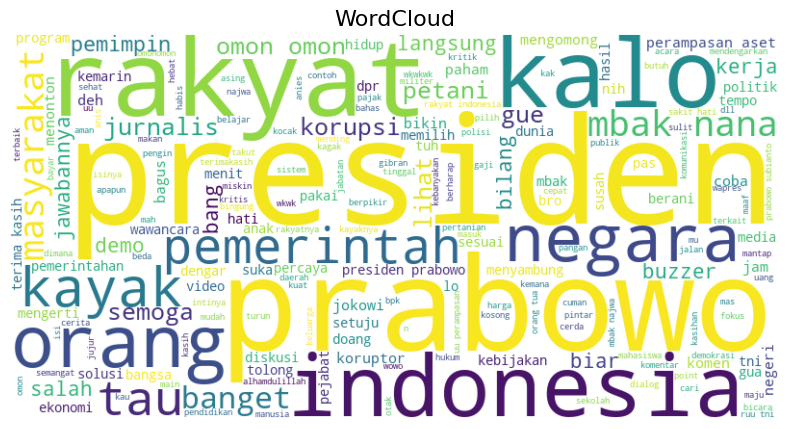

In [21]:
df['text_stopword'] = df['text_stopword'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)

all_tokens = [word for tokens in df['text_stopword'] for word in tokens if word not in listStopwords]
all_words = ' '.join(all_tokens)

wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_words)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.title(f'WordCloud', fontsize=16)
plt.axis('off')
plt.show()

In [22]:
df.head(2)

,Nama Akun,Komentar,Sumber,text_clean,text_casefoldingText,text_slangwords,text_tokenizingText,text_stopword,text_akhir,sentimen
0,@HarianKompasCetak,Sahabat Kompas bisa mengakses bagian 2 dari wa...,Kompas,Sahabat Kompas bisa mengakses bagian dari waw...,sahabat kompas bisa mengakses bagian dari waw...,sahabat kompas bisa mengakses bagian dari wawa...,"[sahabat, kompas, bisa, mengakses, bagian, dar...","[sahabat, kompas, mengakses, wawancara, khusus...",sahabat kompas mengakses wawancara khusus pres...,Neutral
1,@eijisangajiadityabps5018,"Maap, akan ada sesi WAPRES MENJAWAB atau tidak...",Kompas,Maap akan ada sesi WAPRES MENJAWAB atau tidak ...,maap akan ada sesi wapres menjawab atau tidak ...,maaf akan ada sesi wapres menjawab atau tidak ...,"[maaf, akan, ada, sesi, wapres, menjawab, atau...","[maaf, sesi, wapres, spill]",maaf sesi wapres spill,Negative


**Oversampling dengan SMOTE setelah TF-IDF**

In [23]:
print(f"Jumlah data sebelum SMOTE: {len(df)}")
print("Distribusi awal:\n", df['sentimen'].value_counts().to_string())

Jumlah data sebelum SMOTE: 16402
Distribusi awal:
 sentimen
Negative    9196
Neutral     4589
Positive    2617


In [24]:
# TF-IDF tanpa langsung diubah ke array
tfidf = TfidfVectorizer(max_features=10000, stop_words=list(listStopwords), ngram_range=(1, 2))
X_tfidf = tfidf.fit_transform(df['text_akhir'])

y = pd.get_dummies(df['sentimen']).values

X_tfidf_array = X_tfidf.toarray()

c:\Users\lenovo\ProyekNLP\Lib\site-packages\sklearn\feature_extraction\text.py:402: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['baiknya', 'berkali', 'kurangnya', 'mata', 'olah', 'sekurang', 'setidak', 'tama', 'tidaknya'] not in stop_words.
  warnings.warn(


In [25]:
smote = SMOTE(random_state=42)
X_tfidf_smote, y_smote = smote.fit_resample(X_tfidf, np.argmax(y, axis=1))
y_smote = pd.get_dummies(y_smote).values

df_balanced = pd.DataFrame({'text_akhir': [' '.join(doc) for doc in tfidf.inverse_transform(X_tfidf_smote)], 
                            'sentimen': np.argmax(y_smote, axis=1)})

df_balanced['sentimen'] = df_balanced['sentimen'].map({0: 'negatif', 1: 'netral', 2: 'positif'})
print(f"Jumlah data setelah SMOTE: {len(df_balanced)}")
print("Distribusi setelah SMOTE:\n", df_balanced['sentimen'].value_counts().to_string())

Jumlah data setelah SMOTE: 27588
Distribusi setelah SMOTE:
 sentimen
netral     9196
negatif    9196
positif    9196


In [26]:
# Fungsi evaluasi
def evaluate_model(y_true, y_pred, set_name=""):
    accuracy = accuracy_score(y_true, y_pred)
    print(f"\nAkurasi {set_name}: {accuracy * 100:.2f}%")
    print(classification_report(y_true, y_pred, target_names=['negatif', 'netral', 'positif']))
    return accuracy

In [27]:
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=0.0001)

In [28]:
print("\n==== Skema 1: Dense + TF-Idf (80/20) ====")

X_train1, X_test1, y_train1, y_test1 = train_test_split(X_tfidf_smote, y_smote, test_size=0.2, random_state=42)

#Bangun Model
model1 = Sequential([
    Input(shape=(X_tfidf_smote.shape[1],)),
    Dense(192, activation='relu', kernel_regularizer=l2(0.001)),
    Dropout(0.4),
    Dense(128, activation='relu', kernel_regularizer=l2(0.001)),
    Dropout(0.4),
    Dense(3, activation='softmax') 
])

# Compile dengan learning rate terbaik
model1.compile(
    optimizer=Adam(learning_rate=0.0010809378085025996),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Training model
history = model1.fit(
    X_train1, y_train1,
    epochs=30,
    batch_size=64,
    validation_data=(X_test1, y_test1),
    callbacks=[early_stopping, lr_scheduler],
    verbose=1
)


==== Skema 1: Dense + TF-Idf (80/20) ====
Epoch 1/30
345/345 ━━━━━━━━━━━━━━━━━━━━ 8s 22ms/step - accuracy: 0.5620 - loss: 1.0920 - val_accuracy: 0.7762 - val_loss: 0.8345 - learning_rate: 0.0011
Epoch 2/30
345/345 ━━━━━━━━━━━━━━━━━━━━ 7s 21ms/step - accuracy: 0.8056 - loss: 0.7683 - val_accuracy: 0.7800 - val_loss: 0.8351 - learning_rate: 0.0011
Epoch 3/30
345/345 ━━━━━━━━━━━━━━━━━━━━ 7s 21ms/step - accuracy: 0.8371 - loss: 0.7265 - val_accuracy: 0.7818 - val_loss: 0.8362 - learning_rate: 0.0011
Epoch 4/30
345/345 ━━━━━━━━━━━━━━━━━━━━ 7s 20ms/step - accuracy: 0.8701 - loss: 0.6451 - val_accuracy: 0.8255 - val_loss: 0.7258 - learning_rate: 5.4047e-04
Epoch 5/30
345/345 ━━━━━━━━━━━━━━━━━━━━ 7s 20ms/step - accuracy: 0.9013 - loss: 0.5454 - val_accuracy: 0.8238 - val_loss: 0.7079 - learning_rate: 5.4047e-04
Epoch 6/30
345/345 ━━━━━━━━━━━━━━━━━━━━ 7s 21ms/step - accuracy: 0.9065 - loss: 0.5186 - val_accuracy: 0.8391 - val_loss: 0.7044 - learning_rate: 5.4047e-04
Epoch 7/30
345/345 ━━━━━━━━

In [29]:
y_pred_train1 = np.argmax(model1.predict(X_train1), axis=1)
y_pred_test1 = np.argmax(model1.predict(X_test1), axis=1)
y_train1_cat = np.argmax(y_train1, axis=1)
y_test1_cat = np.argmax(y_test1, axis=1)
train_acc1 = evaluate_model(y_train1_cat, y_pred_train1, "Training")
test_acc1 = evaluate_model(y_test1_cat, y_pred_test1, "Testing")

690/690 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step
173/173 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step

Akurasi Training: 96.83%
              precision    recall  f1-score   support

     negatif       0.99      0.96      0.98      7360
      netral       0.92      0.99      0.96      7390
     positif       1.00      0.95      0.97      7320

    accuracy                           0.97     22070
   macro avg       0.97      0.97      0.97     22070
weighted avg       0.97      0.97      0.97     22070


Akurasi Testing: 85.65%
              precision    recall  f1-score   support

     negatif       0.89      0.76      0.82      1836
      netral       0.78      0.89      0.83      1806
     positif       0.91      0.92      0.91      1876

    accuracy                           0.86      5518
   macro avg       0.86      0.86      0.86      5518
weighted avg       0.86      0.86      0.86      5518



In [30]:
sentences = [text.split() for text in df_balanced['text_akhir']]
w2v_model = Word2Vec(sentences, vector_size=200, window=5, min_count=1, workers=4, epochs=20)

tokenizer = Tokenizer(num_words=10000)
tokenizer.fit_on_texts(df_balanced['text_akhir'])
X_seq = tokenizer.texts_to_sequences(df_balanced['text_akhir'])
max_len = 100  # Dikurangi untuk teks pendek
X_pad = pad_sequences(X_seq, maxlen=max_len)

embedding_matrix = np.zeros((10000, 200))
for word, i in tokenizer.word_index.items():
    if i < 10000 and word in w2v_model.wv:
        embedding_matrix[i] = w2v_model.wv[word]

In [31]:
print("\n=== Skema 2: LSTM + Word2Vec (70/30) ===")
# Spliting Data untuk model 2
X_train2, X_test2, y_train2, y_test2 = train_test_split(X_pad, y_smote, test_size=0.3, random_state=42)

model2 = Sequential([
    Embedding(input_dim=10000, output_dim=200, weights=[embedding_matrix], trainable=True),
    Bidirectional(LSTM(256, return_sequences=True, kernel_regularizer=l2(0.005))),
    LSTM(128),
    Dropout(0.5),
    Dense(128, activation='relu', kernel_regularizer=l2(0.005)),
    Dropout(0.5),
    Dense(3, activation='softmax')
])

model2.compile(optimizer=Adam(learning_rate=0.0005), 
               loss='categorical_crossentropy', 
               metrics=['accuracy'])

model2.fit(X_train2, y_train2, epochs=30, 
           batch_size=64, validation_split=0.1, 
           callbacks=[early_stopping, 
                      lr_scheduler], verbose=1)



=== Skema 2: LSTM + Word2Vec (70/30) ===
Epoch 1/30
272/272 ━━━━━━━━━━━━━━━━━━━━ 146s 518ms/step - accuracy: 0.5605 - loss: 2.9815 - val_accuracy: 0.6894 - val_loss: 1.1082 - learning_rate: 5.0000e-04
Epoch 2/30
272/272 ━━━━━━━━━━━━━━━━━━━━ 129s 473ms/step - accuracy: 0.6919 - loss: 1.0426 - val_accuracy: 0.7355 - val_loss: 0.8178 - learning_rate: 5.0000e-04
Epoch 3/30
272/272 ━━━━━━━━━━━━━━━━━━━━ 128s 470ms/step - accuracy: 0.7600 - loss: 0.7732 - val_accuracy: 0.7531 - val_loss: 0.7113 - learning_rate: 5.0000e-04
Epoch 4/30
272/272 ━━━━━━━━━━━━━━━━━━━━ 128s 469ms/step - accuracy: 0.8053 - loss: 0.6214 - val_accuracy: 0.7795 - val_loss: 0.6089 - learning_rate: 5.0000e-04
Epoch 5/30
272/272 ━━━━━━━━━━━━━━━━━━━━ 128s 469ms/step - accuracy: 0.8487 - loss: 0.5011 - val_accuracy: 0.7893 - val_loss: 0.5993 - learning_rate: 5.0000e-04
Epoch 6/30
272/272 ━━━━━━━━━━━━━━━━━━━━ 127s 468ms/step - accuracy: 0.8707 - loss: 0.4455 - val_accuracy: 0.8163 - val_loss: 0.5542 - learning_rate: 5.0000e-0

In [32]:
y_pred_train2 = np.argmax(model2.predict(X_train2), axis=1)
y_pred_test2 = np.argmax(model2.predict(X_test2), axis=1)
y_train2_cat = np.argmax(y_train2, axis=1)
y_test2_cat = np.argmax(y_test2, axis=1)
train_acc2 = evaluate_model(y_train2_cat, y_pred_train2, "Training")
test_acc2 = evaluate_model(y_test2_cat, y_pred_test2, "Testing")

604/604 ━━━━━━━━━━━━━━━━━━━━ 49s 80ms/step
259/259 ━━━━━━━━━━━━━━━━━━━━ 20s 79ms/step

Akurasi Training: 89.27%
              precision    recall  f1-score   support

     negatif       0.91      0.86      0.88      6431
      netral       0.84      0.90      0.87      6471
     positif       0.93      0.91      0.92      6409

    accuracy                           0.89     19311
   macro avg       0.89      0.89      0.89     19311
weighted avg       0.89      0.89      0.89     19311


Akurasi Testing: 81.15%
              precision    recall  f1-score   support

     negatif       0.80      0.76      0.78      2765
      netral       0.77      0.81      0.79      2725
     positif       0.87      0.86      0.87      2787

    accuracy                           0.81      8277
   macro avg       0.81      0.81      0.81      8277
weighted avg       0.81      0.81      0.81      8277



In [33]:
print("\n=== Skema 3: LSTM + Word2Vec (80/20) ===")
# Spliting Data untuk model 2
X_train3, X_test3, y_train3, y_test3 = train_test_split(X_pad, y_smote, test_size=0.2, random_state=42)

model3 = Sequential([
    Embedding(input_dim=10000, output_dim=200, weights=[embedding_matrix], trainable=True),
    Bidirectional(LSTM(256, return_sequences=True, kernel_regularizer=l2(0.005))),
    LSTM(128),
    Dropout(0.5),
    Dense(128, activation='relu', kernel_regularizer=l2(0.005)),
    Dropout(0.5),
    Dense(3, activation='softmax')
])
model3.compile(optimizer=Adam(learning_rate=0.0005), 
               loss='categorical_crossentropy', 
               metrics=['accuracy'])

model3.fit(X_train3, y_train3, epochs=30, 
           batch_size=64, validation_split=0.1, 
           callbacks=[early_stopping, 
                      lr_scheduler], verbose=1)



=== Skema 3: LSTM + Word2Vec (80/20) ===


Epoch 1/30
311/311 ━━━━━━━━━━━━━━━━━━━━ 157s 492ms/step - accuracy: 0.5838 - loss: 2.8550 - val_accuracy: 0.6937 - val_loss: 1.0542 - learning_rate: 5.0000e-04
Epoch 2/30
311/311 ━━━━━━━━━━━━━━━━━━━━ 154s 494ms/step - accuracy: 0.7088 - loss: 0.9829 - val_accuracy: 0.7449 - val_loss: 0.7803 - learning_rate: 5.0000e-04
Epoch 3/30
311/311 ━━━━━━━━━━━━━━━━━━━━ 154s 494ms/step - accuracy: 0.7681 - loss: 0.7328 - val_accuracy: 0.7630 - val_loss: 0.6733 - learning_rate: 5.0000e-04
Epoch 4/30
311/311 ━━━━━━━━━━━━━━━━━━━━ 153s 492ms/step - accuracy: 0.8117 - loss: 0.5935 - val_accuracy: 0.7893 - val_loss: 0.6120 - learning_rate: 5.0000e-04
Epoch 5/30
311/311 ━━━━━━━━━━━━━━━━━━━━ 154s 494ms/step - accuracy: 0.8494 - loss: 0.4928 - val_accuracy: 0.8061 - val_loss: 0.5821 - learning_rate: 5.0000e-04
Epoch 6/30
311/311 ━━━━━━━━━━━━━━━━━━━━ 153s 491ms/step - accuracy: 0.8794 - loss: 0.4273 - val_accuracy: 0.8074 - val_loss: 0.5619 - learning_rate: 5.0000e-04
Epoch 7/30
311/311 ━━━━━━━━━━━━━━━━━━━━ 

In [34]:
y_pred_train3 = np.argmax(model3.predict(X_train3), axis=1)
y_pred_test3 = np.argmax(model3.predict(X_test3), axis=1)
y_train3_cat = np.argmax(y_train3, axis=1)
y_test3_cat = np.argmax(y_test3, axis=1)
train_acc3 = evaluate_model(y_train3_cat, y_pred_train3, "Training")
test_acc3 = evaluate_model(y_test3_cat, y_pred_test3, "Testing")

690/690 ━━━━━━━━━━━━━━━━━━━━ 57s 82ms/step
173/173 ━━━━━━━━━━━━━━━━━━━━ 14s 79ms/step

Akurasi Training: 89.11%
              precision    recall  f1-score   support

     negatif       0.89      0.88      0.88      7360
      netral       0.85      0.90      0.87      7390
     positif       0.95      0.89      0.92      7320

    accuracy                           0.89     22070
   macro avg       0.89      0.89      0.89     22070
weighted avg       0.89      0.89      0.89     22070


Akurasi Testing: 80.52%
              precision    recall  f1-score   support

     negatif       0.77      0.78      0.78      1836
      netral       0.76      0.80      0.78      1806
     positif       0.89      0.83      0.86      1876

    accuracy                           0.81      5518
   macro avg       0.81      0.80      0.81      5518
weighted avg       0.81      0.81      0.81      5518



In [35]:
def predict_text_dense(input_text, model, tokenizer):

    new_text_tfidf = tokenizer.transform([input_text]).toarray()
    prediction = model.predict(new_text_tfidf)
    predicted_class = np.argmax(prediction, axis=1)[0]
    labels = ['negative', 'neutral', 'positive']
    predicted_probs = prediction[0]
    
    print(f"Teks: {input_text}")
    print(f"Prediksi Sentimen: {labels[predicted_class]}")
    print(f"Probabilitas: Negative: {predicted_probs[0]:.4f}, Neutral: {predicted_probs[1]:.4f}, Positive: {predicted_probs[2]:.4f}")
    
    return labels[predicted_class], predicted_probs


In [36]:
predict_text_dense("omon omon",model1, tfidf)
predict_text_dense("Terima kasih prabowo",model1, tfidf)
predict_text_dense("Menarik jawaban yang diberikan, patut dipertimbangkan lebih lanjut",model1, tfidf)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
Teks: omon omon
Prediksi Sentimen: negative
Probabilitas: Negative: 0.9388, Neutral: 0.0605, Positive: 0.0007
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Teks: Terima kasih prabowo
Prediksi Sentimen: positive
Probabilitas: Negative: 0.0007, Neutral: 0.0001, Positive: 0.9992
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Teks: Menarik jawaban yang diberikan, patut dipertimbangkan lebih lanjut
Prediksi Sentimen: neutral
Probabilitas: Negative: 0.0615, Neutral: 0.8457, Positive: 0.0929


('neutral', array([0.06145657, 0.8456613 , 0.09288214], dtype=float32))

In [37]:
def predict_text_lstm(text, tokenizer, model):
    # Tokenisasi
    sequence = tokenizer.texts_to_sequences([text])
    
    # Padding
    padded_sequence = pad_sequences(sequence, padding='post', truncating='post')
    
    # Prediksi
    prediction = model.predict(padded_sequence)
    predicted_label = np.argmax(prediction, axis=1)[0]
    
    # Label mapping 
    label_map = {0: "negatif", 1: "netral", 2: "positif"}
    
    # Hasil
    print(f"Teks: {text}")
    print(f"Prediksi: {label_map[predicted_label]}")
    print(f"Probabilitas: {prediction[0]}")
    
    return label_map[predicted_label]

In [38]:
predict_text_lstm("omon omon", tokenizer, model2)
predict_text_lstm("Terima kasih prabowo", tokenizer, model2)
predict_text_lstm("Menarik jawaban yang diberikan, patut dipertimbangkan lebih lanjut", tokenizer, model2)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 355ms/step
Teks: omon omon
Prediksi: negatif
Probabilitas: [0.65755135 0.2316086  0.11084007]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Teks: Terima kasih prabowo
Prediksi: positif
Probabilitas: [0.08543137 0.30046502 0.61410356]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Teks: Menarik jawaban yang diberikan, patut dipertimbangkan lebih lanjut
Prediksi: netral
Probabilitas: [0.23108307 0.5878345  0.18108244]


'netral'

In [39]:
predict_text_lstm("omon omon", tokenizer, model3)
predict_text_lstm("Terima kasih prabowo", tokenizer, model3)
predict_text_lstm("Menarik jawaban yang diberikan, patut dipertimbangkan lebih lanjut", tokenizer, model3)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 359ms/step
Teks: omon omon
Prediksi: negatif
Probabilitas: [0.5452308 0.2882518 0.1665174]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Teks: Terima kasih prabowo
Prediksi: positif
Probabilitas: [0.02810583 0.19784932 0.77404493]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Teks: Menarik jawaban yang diberikan, patut dipertimbangkan lebih lanjut
Prediksi: netral
Probabilitas: [0.25544736 0.53057086 0.2139817 ]


'netral'